In [1]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
#TODO: graphing colors
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rcParams.update({'font.size': 22})

# Analyze Cost of Chemical Space (with MA)

## Step 1: Sample from cost of chemical space

Both randomly & uniformly across price ranges

In [3]:
# Read in data (in Orkney)
cost_df = pd.read_csv("U:\\Cost_of_chemical_space\\reaxys_database\\purchasable.csv")

print(cost_df.head())

FileNotFoundError: [Errno 2] No such file or directory: 'U:\\Cost_of_chemical_space\\reaxys_database\\purchasable.csv'

In [5]:
## Random sample (50k)

random_df = cost_df.sample(n=50000)

random_df.to_csv("Data/Cost/random_cost_50k.csv")

In [29]:
## Uniform sampling over percentiles
labels = list(range(1,101,2))
cost_df["percentile"] = pd.qcut(cost_df.price, q=50, duplicates="drop", labels=labels)


In [32]:
#Randomly sample 1000 from each percentile
random_df = pd.concat([cost_df[cost_df["percentile"] == label].sample(1000) for label in labels])

print(random_df)

random_df.to_csv("Data/Cost/random_cost_percentiles_50k.csv")

                 CAS         price  \
282683    65100-04-1      2.224000   
28490     18595-14-7      2.600000   
254038     4515-21-3      1.862600   
255848      108-24-7      0.015346   
196580     2832-45-3      2.600000   
...              ...           ...   
163096   831249-87-7   7290.000000   
323199   660846-41-3  24019.200000   
95359            NaN  23790.000000   
191061  2092468-21-6   9180.000000   
328199     5205-34-5  24742.000000   

                                                     name    supplier  \
282683           3-Methacryloxypropylmethyldiethoxysilane  fluorochem   
28490                     methyl 4-amino-3-methylbenzoate     enamine   
254038          N-Benzyloxycarbonyl-DL-aspartic acid, 95%        alfa   
255848                             Acetic anhydride, 99+%        alfa   
196580                          sodium hexane-1-sulfonate     enamine   
...                                                   ...         ...   
163096  (2-chloro-4-nitrophenyl)

## Step 2: Analyze MA/cost correlation

Get MAs, merge with cost

MAs from AssemblyGo algorithm, timeout=300



In [5]:
#Get MA values
def get_MA(fp):
    """ Get AssemblyGo MA value

    Args:
        fp (str): filepath to a particular .txt AssemblyGo output file

    Returns:
        label (str): label of the compound which was analzyed
        MA (int): assemblyGo MA value
        time (float): how much time it took to complete each MA run
    """
    with open(fp) as f:
        lines = f.readlines()

    try:
        #molfile will be the last element in 0th line
        label = lines[0].split()[-1].split("/")[-1].split(".")[0]

        #MA will be last elemnt in -2nd line (will be an int)
        MA = int(lines[-2].split()[-1])

        time = float(lines[-1].split()[-1])
        
        return label, MA, time

    except:
        return None, None, None



In [ ]:
#Get list of MA values, create a pandas dataframe of label/MA values
fp = "Data/AssemblyValues/CostRandom/"
result_files = [x for x in os.listdir(fp) if x.endswith(".txt")]

results = []
for f in tqdm(result_files):
    label, MA, time = get_MA(fp + f)
    results.append({"label": label, "MA": MA, "time": time})
    

100%|██████████| 50000/50000 [00:09<00:00, 5458.09it/s]


In [6]:
results_df = pd.DataFrame(results)
results_df = results_df.dropna() #Drop failed runs (only 24 failed)
results_df = results_df.astype({"label":"int"})

print(results_df)

        label    MA        time
0       27869  12.0    4.505859
1      238007   9.0    0.602745
2       57356  11.0    0.003598
3      153178   8.0    0.109302
4      284840  11.0    3.163091
...       ...   ...         ...
49995  266604  11.0  299.916593
49996  197645   7.0    0.054040
49997  324345  27.0  299.813292
49998  201847   8.0    0.253747
49999  102448  12.0   13.968902

[49976 rows x 3 columns]


In [7]:
## Merge random cost sample & MA database
random_cost_df = pd.read_csv("Data/AssemblyValues/CostRandom/random_cost_50k.csv")
random_cost_df = random_cost_df.astype({"Unnamed: 0": "int"})

#print(random_cost_df.head())

full_df = random_cost_df.merge(results_df, left_on="Unnamed: 0", right_on="label", how="outer")

print(full_df.head())


   Unnamed: 0           CAS     price  \
0      312645     2446-69-7   13.5664   
1      217713           NaN   75.9000   
2      144938     1759-55-3   58.8000   
3       81564  2095410-18-5  421.1000   
4      171801  1864299-18-2  169.3000   

                                                name supplier  reaxys_id  \
0                       4-Hexylphenol >= 98.0 % HPLC    sigma     387122   
1                3,6-dichloropyrazine-2-carbonitrile  enamine   14085485   
2             2,2-dimethylcyclopropane-1-carboxamide  enamine    2612300   
3  2-amino-4-chloro-5-fluorobenzene-1-thiol hydro...  enamine         -1   
4                      2-(bromomethyl)-6-phenyloxane  enamine         -1   

   n_references  as_reagent  as_product                 smiles     label   MA  \
0           169         164          22      CCCCCCc1ccc(O)cc1  312645.0  8.0   
1            26          29          20      N#Cc1nc(Cl)cnc1Cl  217713.0  7.0   
2            28          75          11        CC1(C)

Text(0.5, 1.0, 'Reaxys Price/MA Test: 50k Compounds')

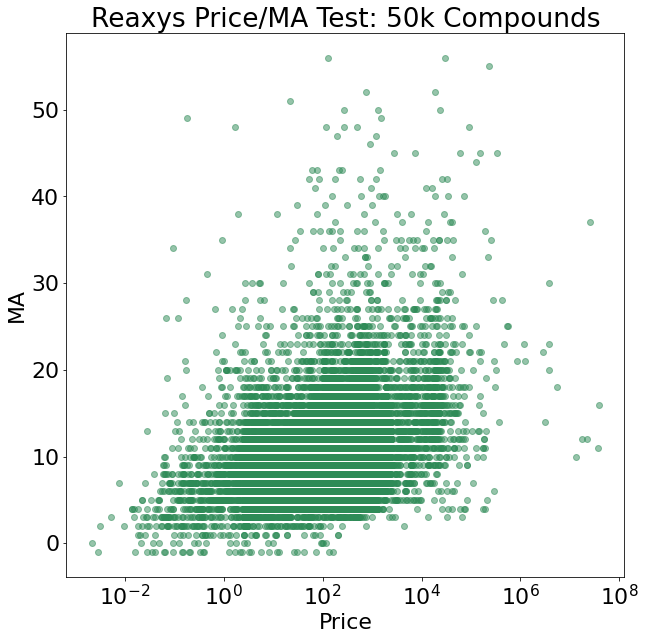

In [8]:
plt.figure(figsize=(10,10))

plt.scatter(full_df["price"], full_df["MA"], alpha=0.5, color="seagreen")

plt.xscale("log")

plt.xlabel("Price")
plt.ylabel("MA")
plt.title("Reaxys Price/MA Test: 50k Compounds")

### Filter by time

All runs which were timed out (>299 time) are removed

*Note 1: only ~4000 are removed, but it removed all MA values over 25*

*Note 2: KDE plot of price shows a uniform density across lower prices - this is accurate, I believe*

In [10]:
timeFiltered_df = full_df[full_df["time"] <= 299]

print(len(timeFiltered_df))

46187


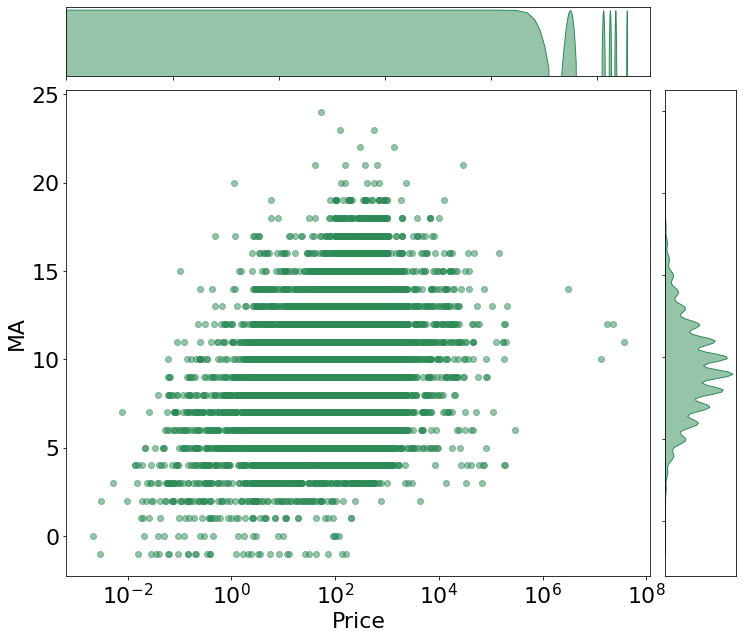

In [50]:
from matplotlib.gridspec import GridSpec

#Combine KDE & scatter plot
fig = plt.figure(figsize=(12,12))
gs = GridSpec(8,8)
ax_scatter = fig.add_subplot(gs[1:7, 0:7])
ax_hist_y = fig.add_subplot(gs[0,0:7])
ax_hist_x = fig.add_subplot(gs[1:7, 7])

#Scatter plot
ax_scatter.scatter(timeFiltered_df["price"], timeFiltered_df["MA"], alpha=0.5, color="seagreen")
ax_scatter.set_xscale("log")
ax_scatter.set_xlabel("Price")
ax_scatter.set_ylabel("MA")

#KDE distribution - price
sns.kdeplot(timeFiltered_df["price"], ax=ax_hist_y, color="seagreen", fill=True, alpha=0.5)
ax_hist_y.tick_params(labelbottom=False, labelleft=False, left=False)
ax_hist_y.set_xlim(0.001, 1e8)
ax_hist_y.set_xlabel("")
ax_hist_y.set_ylabel("")
ax_hist_y.set_xscale("log")
ax_hist_y.set_yscale("log")

#KDE distribution - MA
sns.kdeplot(y = timeFiltered_df["MA"], ax=ax_hist_x, color="seagreen", fill=True, alpha=0.5)

ax_hist_x.tick_params(labelbottom=False, labelleft=False, bottom=False)
ax_hist_x.set_xlabel("")
ax_hist_x.set_ylabel("")

plt.show()

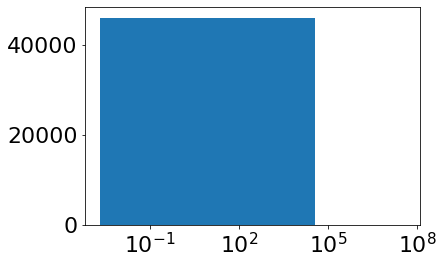

In [43]:
### Testing of price distributions
plt.hist(timeFiltered_df["price"], bins=1000)

plt.xscale("log")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'logx'
  cset = contour_func(


<Figure size 720x720 with 0 Axes>

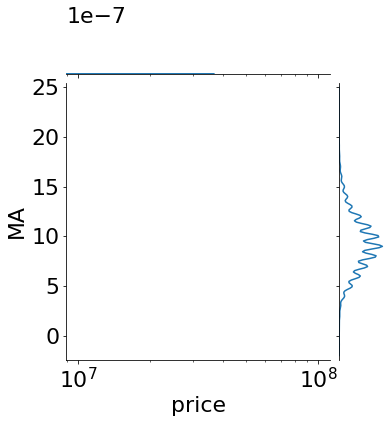

In [16]:
plt.figure(figsize=(10,10))

g = sns.jointplot(x=timeFiltered_df["price"], y=timeFiltered_df["MA"], kind="kde", logx=True)

g.ax_joint.set_xscale('log')


## Uniformly Sampled Cost Samples

In [6]:
#Get list of MA values, create a pandas dataframe of label/MA values
fp = "Data/AssemblyValues/CostRandomPercentiles/"
result_files = [x for x in os.listdir(fp) if x.endswith(".txt")]

results = []
for f in tqdm(result_files):
    label, MA, time = get_MA(fp + f)
    results.append({"label": label, "MA": MA, "time": time})

results_df = pd.DataFrame(results)
results_df = results_df.dropna() #Drop failed runs (only 24 failed)
results_df = results_df.astype({"label":"int"})

print(results_df)

100%|██████████| 50000/50000 [00:07<00:00, 6936.65it/s]


        label    MA       time
0       67295  12.0   0.735633
1      112642  11.0   2.085211
2      312836  10.0  54.403892
3      189462  10.0   0.001994
4       95003   5.0   0.243892
...       ...   ...        ...
49995    3885  14.0   3.749282
49996  236033   9.0   0.002969
49997  220651   9.0   0.480807
49998  284859  10.0   0.130463
49999   94304   9.0  12.685056

[49982 rows x 3 columns]


In [7]:
## Merge random cost sample & MA database
random_cost_df = pd.read_csv("Data/Cost/random_cost_percentiles_50k.csv")
random_cost_df = random_cost_df.astype({"Unnamed: 0": "int"})

#print(random_cost_df.head())

full_df = random_cost_df.merge(results_df, left_on="Unnamed: 0", right_on="label", how="outer")

print(full_df.head())

   Unnamed: 0         CAS     price  \
0      282683  65100-04-1  2.224000   
1       28490  18595-14-7  2.600000   
2      254038   4515-21-3  1.862600   
3      255848    108-24-7  0.015346   
4      196580   2832-45-3  2.600000   

                                        name    supplier  reaxys_id  \
0   3-Methacryloxypropylmethyldiethoxysilane  fluorochem         -1   
1            methyl 4-amino-3-methylbenzoate     enamine    2830706   
2  N-Benzyloxycarbonyl-DL-aspartic acid, 95%        alfa    2336721   
3                     Acetic anhydride, 99+%        alfa         -1   
4                  sodium hexane-1-sulfonate     enamine    3727014   

   n_references  as_reagent  as_product                            smiles  \
0            -1          -1          -1    C=C(C)C(=O)OCCC[Si](C)(OCC)OCC   
1           123         608           5             COC(=O)c1ccc(N)c(C)c1   
2            34          20           2  O=C(O)CC(NC(=O)OCc1ccccc1)C(=O)O   
3            -1          -1   

Text(0.5, 1.0, 'Reaxys Price/MA Test: 50k Compounds')

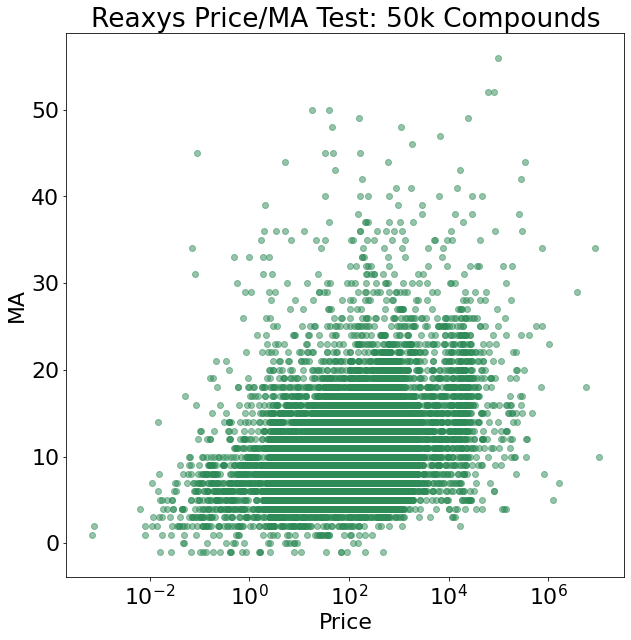

In [8]:
plt.figure(figsize=(10,10))

plt.scatter(full_df["price"], full_df["MA"], alpha=0.5, color="seagreen")

plt.xscale("log")

plt.xlabel("Price")
plt.ylabel("MA")
plt.title("Reaxys Price/MA Test: 50k Compounds")

In [9]:
timeFiltered_df = full_df[full_df["time"] <= 299]

print(len(timeFiltered_df))

46033


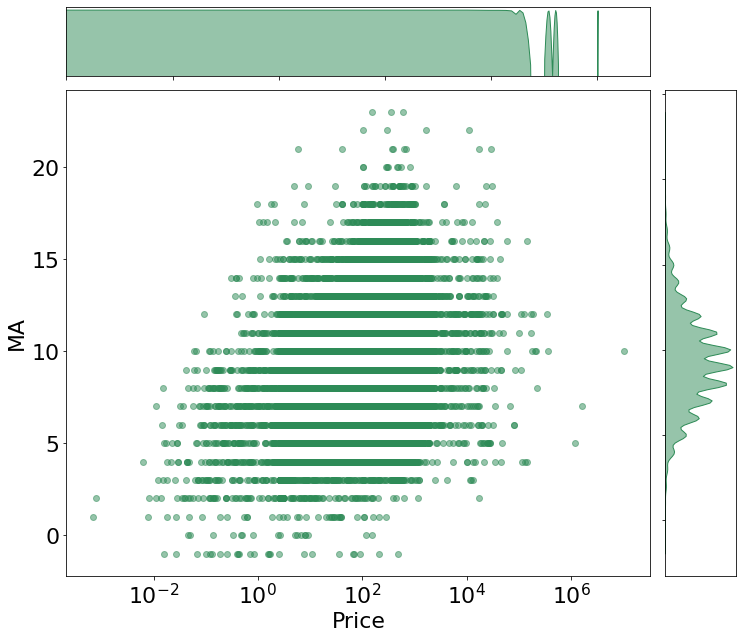

In [10]:
from matplotlib.gridspec import GridSpec

#Combine KDE & scatter plot
fig = plt.figure(figsize=(12,12))
gs = GridSpec(8,8)
ax_scatter = fig.add_subplot(gs[1:7, 0:7])
ax_hist_y = fig.add_subplot(gs[0,0:7])
ax_hist_x = fig.add_subplot(gs[1:7, 7])

#Scatter plot
ax_scatter.scatter(timeFiltered_df["price"], timeFiltered_df["MA"], alpha=0.5, color="seagreen")
ax_scatter.set_xscale("log")
ax_scatter.set_xlabel("Price")
ax_scatter.set_ylabel("MA")

#KDE distribution - price
sns.kdeplot(timeFiltered_df["price"], ax=ax_hist_y, color="seagreen", fill=True, alpha=0.5)
ax_hist_y.tick_params(labelbottom=False, labelleft=False, left=False)
ax_hist_y.set_xlim(0.001, 1e8)
ax_hist_y.set_xlabel("")
ax_hist_y.set_ylabel("")
ax_hist_y.set_xscale("log")
ax_hist_y.set_yscale("log")

#KDE distribution - MA
sns.kdeplot(y = timeFiltered_df["MA"], ax=ax_hist_x, color="seagreen", fill=True, alpha=0.5)

ax_hist_x.tick_params(labelbottom=False, labelleft=False, bottom=False)
ax_hist_x.set_xlabel("")
ax_hist_x.set_ylabel("")

plt.show()